In [1]:
import calibrators
import simulators
import logging
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(filename='data/app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.DEBUG)

In [3]:
def print_model_status(calibrator, model):
    print('model parameters: ' + str(model.params))
    print('calibrator model parameters: ' + str(calibrator.model_params))
    print('model parameters difference: ' + str((np.asarray(model.params) - np.asarray(calibrator.model_params)).tolist()))
    print('\nsamping point: ' + str(calibrator.sample_queue[-1].inputs))
    print('sampling value: ' + str(calibrator.sample_queue[-1].output))
    print('current observe: ' + str(model.observe(calibrator.sample_queue[-1].inputs)))

# Initialize Model and Calibrator

### Initial Model Parameters

In [4]:
model_params = [0.7991353, 2.2477762]

### Initialize

In [5]:
model = simulators.SimulatorModel(list(model_params))
calib = calibrators.SlidingWindowCalibrator(model, num_resamples=1, num_samples=12)
calib.initialize()

initializing...
initialization done!
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 5.6624e-01, final cost 3.1834e-18, first-order optimality 3.81e-09.


/anaconda3/envs/polarization/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`xtol`", EPS))
simulators.py:155: OptimizeWarning: Unknown solver options: gtol
  options={'gtol': 1e-6, 'disp': verbose > 0, 'xtol': 1e-15}


In [6]:
print_model_status(calib, model)

model parameters: [0.7991353, 2.2477762]
calibrator model parameters: [ 0.7991353  2.2477762]
model parameters difference: [6.854667944367066e-10, -2.258059073056984e-09]

samping point: [2.4646128029146057, 0.92945520328508757]
sampling value: 1.38777878078e-16
current observe: 1.38777878078e-16


# Tracking

In [7]:
model.params = list(model_params)
calib.model_params = list(model_params)

### Add a Small Perturbation

In [8]:
params_change = [1E-3, 5E-2]

In [9]:
for i in range(len(model.params)):
    model.params[i] = model_params[i] + params_change[i]

In [10]:
print_model_status(calib, model)

model parameters: [0.8001353, 2.2977762]
calibrator model parameters: [0.7991353, 2.2477762]
model parameters difference: [0.0010000000000000009, 0.04999999999999982]

samping point: [2.4646128029146057, 0.92945520328508757]
sampling value: 1.38777878078e-16
current observe: 0.000402022655257


### Track

In [11]:
calib.track(num_observes=5)

/anaconda3/envs/polarization/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


In [12]:
print_model_status(calib, model)

model parameters: [0.8001353, 2.2977762]
calibrator model parameters: [0.8001353046841673, 2.2977762179848638]
model parameters difference: [-4.684167276280959e-09, -1.798486382043052e-08]

samping point: [2.4146127531251347, 0.92695686817166312]
sampling value: 8.32667268469e-16
current observe: 8.32667268469e-16


# Simulation

In [13]:
def plot_tracking(model_observes, model_observes_no_tracking, model_params_real, model_params_guess):
    plt.figure()
    pd.DataFrame(
        {"tracking": model_observes, "no tracking": model_observes_no_tracking}
    ).plot(logy=True, legend=True, title='system power')
    plt.show()
    
    tracking_dif = np.abs(np.asarray(model_params_real) - np.asarray(model_params_guess))
    plt.figure()
    pd.DataFrame(
        {"h1": tracking_dif[:, 0], "h2": tracking_dif[:, 1]}
    ).plot(logy=True, legend=True, title='model params tracking error')
    #pd.Series(tracking_dif).plot(logy=True, title='model params tracking error')
    plt.show()

In [14]:
def model_params_random_drift(model_params, drift_scale):
    drift = ((np.random.rand(len(model_params)) - 0.5) * 2.0).tolist()
    
    for i in range(len(model_params)):
        model_params[i] += drift[i] * drift_scale
        
    model_params[0] = min(max(model_params[0], 0), 1.0)
    model_params[1] = min(max(model_params[1], 0), np.pi)
    
def model_params_sin_drift(model_params, drift_scale):
    
    model_params[0] += drift_scale
    model_params[0] = min(max(model_params[0], 0), 1.0)
    
    # drift = (np.random.rand(1) - 0.5) * 2.0
    #model_params[1] += drift[0] * drift_scale * 3
    model_params[1] += drift_scale
    model_params[1] = min(max(model_params[1], 0), 2 * np.pi)

### Define Model Parameters

In [27]:
model_params = [0.01, 2.2477762]
drift_scale = 0.01
NSR = 0.03

num_records = int((1.0 - model_params[0]) / drift_scale)
model_params_records = list()
model_params_guess = list()
model_observes = list()
model_observes_t0 = list()

### Simulation

In [28]:
class NoiseSimulatorModel(simulators.SimulatorModel):
    def __init__(self, params, nsr):
        super(NoiseSimulatorModel, self).__init__(params)
        self.nsr = nsr
        
    def observe(self, inputs):
        val = super(NoiseSimulatorModel, self).observe(inputs)
        noise_val = np.random.normal(0, val * self.nsr / 3.0)
        noise_val = min(noise_val, val * self.nsr) 
        logging.debug("noise: " + str(noise_val))
        val += noise_val
        return max(0.0, min(val, 1.0))

In [29]:
model = NoiseSimulatorModel(list(model_params), NSR)
#model = simulators.SimulatorModel(list(model_params))

calib = calibrators.SlidingWindowCalibrator(model, num_resamples=1, num_samples=10)
calib.initialize(num_observes=10)
model_input_t0 = calib.sample_queue[-1].inputs
print_model_status(calib, model)

initializing...
initialization done!
`xtol` termination condition is satisfied.
Function evaluations 25, initial cost 7.3206e-01, final cost 1.0360e-05, first-order optimality 1.50e-11.
model parameters: [0.01, 2.2477762]
calibrator model parameters: [ 0.00982346  2.25115114]
model parameters difference: [0.00017654266907208768, -0.0033749399562084115]

samping point: [2.4612378497917136, 2.9430399519612931]
sampling value: 9.09804219144e-07
current observe: 9.01931286689e-07


In [30]:
for t in range(num_records):
    
    # recording model parameters
    model_params_records.append(list(model_params))
    model_params_guess.append(list(calib.model_params))
    model_observes.append(model.observe(calib.sample_queue[-1].inputs))
    model_observes_t0.append(model.observe(model_input_t0))
    
    # model parameter drift
    model_params_sin_drift(model_params, drift_scale)
    model.params = model_params
    
    # tracking
    calib.track(epsilon=0.001, num_observes=15, tol=1E-4, threshold=1E-4)

<Figure size 432x288 with 0 Axes>

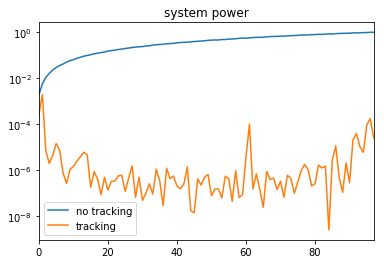

<Figure size 432x288 with 0 Axes>

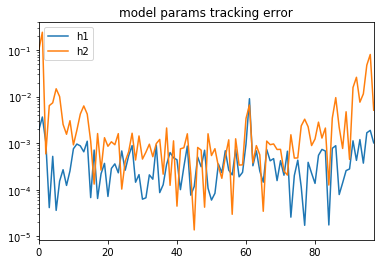

In [31]:
plot_tracking(model_observes[1:], model_observes_t0[1:], model_params_records[1:], model_params_guess[1:])